In [133]:
# Data reading 
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

#Data visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [25]:
!pip install pipreqsnb
!pipreqsnb
!python3 -m spacy download en_core_web_sm

Exception occurred while working on file /Users/julkakubisa/gilmore_girls_network/script_scrape.ipynb, cell 4/5
Traceback (most recent call last):
  File "/opt/anaconda3/bin/pipreqsnb", line 8, in <module>
    sys.exit(main())
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 130, in main
    raise e
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "/opt/anaconda3/lib/python3.9/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 2
    for item_link in item_links[]:
                                ^
SyntaxError: invalid syntax


In [52]:
# Load datasets 
characters = pd.read_csv("data/characters_list.csv", sep='\t') # List of characters
script = pd.read_csv("data/Gilmore_Girls_Lines.csv", sep=',')

In [57]:
script

,Character,Line,Season
0,Lorelai,"Please, Luke. Please, please, please.",1
1,Luke,How many cups have you had this morning?,1
2,Lorelai,None.,1
3,Luke,Plus...,1
4,Lorelai,"Five, but yours is better.",1
...,...,...,...
134176,Rory,Well It wasn't very flattering.,7
134177,Lorelai,Well how will people know you're the world's g...,7
134178,Rory,I don't know.,7
134179,Lorelai,I guess they'll just have to read your stuff.,7


In [107]:
# Count lines by character
char_lines = script.groupby(['Character'], as_index=False)['Line'].count().sort_values(['Line'], ascending=False)

In [109]:
# Percent of lines said by character
char_lines['Percent'] = char_lines['Line']/char_lines['Line'].sum()

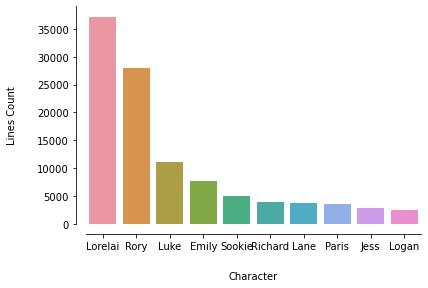

In [151]:
# Barplot of said lines 
sns.set_palette("Set2")
fig = sns.barplot(data=char_lines[:10], x="Character", y="Line")
plt.ylabel("Lines Count", labelpad=20)
plt.xlabel("Character",labelpad=20)
sns.despine(offset=10)
fig = sns.color_palette("Set2")

In [184]:
# Number of character per season
seasons_char= script.groupby(['Season'], as_index=False)['Character'].nunique().sort_values('Character', ascending=False)

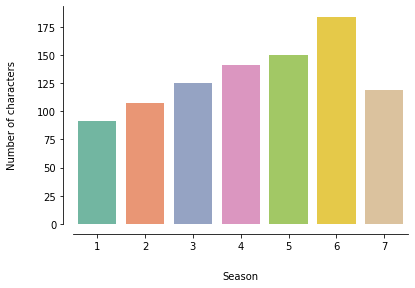

In [189]:
# Barplot of seasons distribution 
sns.set_palette("Set2")
fig2 = sns.barplot(data=seasons_char, x="Season", y="Character")
plt.ylabel("Number of characters", labelpad=20)
plt.xlabel("Season",labelpad=20)
sns.despine(offset=10)
fig2 = sns.color_palette("Set2")